In [543]:
#Import Bibliotecas
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [544]:
#grunddaten
inhouse_pv = 1.35 #leistung der PV Anlage in MW
capital_cost_pv = 800000 # Kosten der PV Anlage in € pro MW
capital_cost_wärmepumpe = 1000000 # Kosten der Wärmepumpe in € pro MW
stromkosten = 150 # €/MWh

In [ ]:
# ===========
# Zeitprofile
# ===========

# Lade das ninja_pv Solar-Profil für Deutschland (51.16°N, 13°E)
renewable_profile_solar = pd.read_csv("pv_profile.csv", usecols=["electricity"]) ["electricity"].astype(float)  # Stündliches, normiertes PV-Erzeugungsprofil
# Building load als csv datei einlesen (kW → MW)
electric_load_profile = pd.read_csv("building_load_G4.csv", usecols=["Last [kW]"])["Last [kW]"].astype(float) / 1000  # In MW

# Building thermal load als csv datei einlesen (kW → MW)
thermal_load_bww = pd.read_csv("bww_load.csv", header=None)[1].astype(float) / 1000  # In MW
thermal_load_heating = pd.read_csv("building_heat_load.csv", header=None)[1].astype(float) / 1000  # In MW

# Temperatur profile
temperature_profile = pd.read_csv("temprature_profile.csv", header=None)[2].astype(float)

# Fleet load profile (kW → MW)
fleet_load_profile = pd.read_csv("fleet_load.csv", header=None)[1].astype(float) / 1000  # In MW

(0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
        ... 
 8755    0.0
 8756    0.0
 8757    0.0
 8758    0.0
 8759    0.0
 Name: Last [kW], Length: 8760, dtype: float64,
 5)

In [546]:
# ===============================
#netzwerk erstellen with_batterie
# ===============================
with_battery = pypsa.Network()
with_battery.set_snapshots(range(8760))

In [547]:
#hinzufügen bus
with_battery.add("Bus", name="electricity bus", carrier="electricity")
with_battery.add("Bus", name= "h_bus", carrier="heat")
with_battery.add("Bus", name= "h_bus2", carrier="heat")


In [548]:
#hinzufügen generatoren
with_battery.add("Generator", name="PV", bus="electricity bus", p_nom=inhouse_pv, p_max_pu=renewable_profile_solar, marginal_cost=0, overwrite=True )  # PV Betriebskosten: 1 €/MWh
with_battery.add("Generator", name="Grid", bus="electricity bus", p_nom_extendable=True, marginal_cost=stromkosten, overwrite=True )  # Netzbezugskosten: 200 €/MWh

In [ ]:
#hinzufügen last
with_battery.add("Load", name="building_load", bus="electricity bus", p_set=electric_load_profile)
with_battery.add("Load", name="fleet_load", bus="electricity bus", p_set=fleet_load_profile)
with_battery.add("Load", name="DHW_Load",bus="h_bus", p_set=thermal_load_bww)
with_battery.add("Load", name="heating_Load",bus="h_bus2", p_set=thermal_load_heating)


SyntaxError: positional argument follows keyword argument (566363616.py, line 3)

In [ ]:
#wärmepumpen

# Umgebungstemperatur in °C
temp        = [-20, -15, -10,  -7,   2,   7,  10,  20,  30,  35] 
# Elektrische Leistungsaufnahme in kW 
el_power    = [10.2, 10.4, 10.6, 10.8, 11.2, 11.5, 11.7, 12.0, 12.2, 12.5] 
# Leistungszahl (COP) der Wärmepumpe bei 35°C Vorlauftemperatur
cop         = [1.65, 1.90, 2.20, 2.50, 3.40, 4.60, 5.10, 6.20, 7.10, 7.50]
# Nominale thermische Leistung (P_th) bei A7/W35 (Referenzpunkt)
hp_p_nom_kw = 39.5  # kW (thermisch)
hp_p_nom    = hp_p_nom_kw / 1000  # MW (umgerechnet für PyPSA!)

# Interpolation für jede Stunde des Jahres
cop_profile = np.interp(temperature_profile, temp, cop)
el_p_pu_profile = np.interp(temperature_profile, temp, el_power) / hp_p_nom_kw

# Wärmepumpe 1: Raumheizung (h_bus2)
with_battery.add("Link", name="h_pump", 
                 bus0="electricity bus", 
                 bus1="h_bus2", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_nom_extendable=True,  # Wichtig: True für Optimierung
                 capital_cost=capital_cost_wärmepumpe)  

# Wärmepumpe 2: Warmwasser (h_bus)
with_battery.add("Link", name="h_pump2", 
                 bus0="electricity bus", 
                 bus1="h_bus", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_nom_extendable=True,  # Wichtig: True für Optimierung
                 capital_cost=capital_cost_wärmepumpe)  

print(f"hp_p_nom in MW: {hp_p_nom:.4f} MW")
print(f"COP-Profil erstellt mit {len(cop_profile)} Stunden")

hp_p_nom in MW: 0.0395 MW
COP-Profil erstellt mit 8760 Stunden


In [ ]:
#hinzufügen Wärmespeicher
with_battery.add("Store", name="DHW_Storage", bus="h_bus", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=300000)  
with_battery.add("Store", name="Thermal_Storage", bus="h_bus2", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=300000)


In [ ]:
#hinzufügen Batteriespeicher
with_battery.add("Store", name="Battery", bus="electricity bus", carrier="electricity", e_nom_extendable=True, e_cyclic=True, capital_cost=400000)

In [ ]:
# PV-Leistungsvariationen (in MW) - MIT 1x als Baseline
pv_variations = inhouse_pv * np.array([1, 1.5, 2, 2.5, 3, 10])  # 100%-1000% der ursprünglichen PV-Leistung

# Spaltennamen definieren
column_names = ['PV-Leistung 1', 'PV-Leistung 1.5', 'PV-Leistung 2', 'PV-Leistung 2.5', 'PV-Leistung 3', 'PV-Leistung 10']

# DataFrame mit korrekten Spaltennamen erstellen
df_results = pd.DataFrame(
    columns=column_names, 
    index=['Netzbezug (MWh)', 'Autarkie (%)'],#speicn netzb
    dtype=float
)

# Schleife zur Berechnung der Netzbezug und Autarkie für ALLE PV-Leistungen (inkl. Baseline)
for i, pv_power in enumerate(pv_variations):
    with_battery.generators.at["PV", "p_nom"] = pv_power
    with_battery.optimize(solver_name='highs')
    
    # Netzbezug berechnen
    grid_energy = with_battery.generators_t.p["Grid"].sum()
    
    # Autarkie berechnen
    pv_energy = with_battery.generators_t.p["PV"].sum()
    total_electricity_demand = (with_battery.loads_t.p["building_load"].sum() + 
                                with_battery.loads_t.p["fleet_load"].sum() + 
                                with_battery.links_t.p0["h_pump"].sum() + 
                                with_battery.links_t.p0["h_pump2"].sum())
    autarky_calc = (pv_energy / total_electricity_demand) * 100 if total_electricity_demand > 0 else 0
    
    # Verwende den Index direkt für die Spaltennamen
    col_name = column_names[i]
    
    df_results.loc['Netzbezug (MWh)', col_name] = grid_energy
    df_results.loc['Autarkie (%)', col_name] = autarky_calc

# Tabelle anzeigen
print("\nSensitivitätsanalyse: Einfluss der PV-Leistung auf Netzbezug und Autarkie")
print(df_results.round(2))

Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 334.48it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-eb5sorh3 has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e-08, 1e+00]
Presolving model
78840 rows, 65440 cols, 205595 nonzeros  0s
67795 rows, 54395 cols, 186926 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53819 cols, 189439 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53819(-33787); nonzeros 189439(-143447) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6640261674e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.59e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      42121     5.5940640754e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-eb5sorh3
Model status        : Optimal
Simplex   iterations: 42121
Objective value     :  5.5940640752e+05
P-D objective error :  6.1390947228e-15
HiGHS run time      :          0.80


('ok', 'optimal')

In [ ]:
# Amortisationszeit der Pv & Wärmepumpe & Speicher

# Speicher-Investitionskosten
battery_capacity = with_battery.stores.at["Battery", "e_nom_opt"]  # MWh
battery_cost = with_battery.stores.at["Battery", "capital_cost"]  # €/MWh
battery_investment = battery_capacity * battery_cost

thermal_storage_capacity = with_battery.stores.at["Thermal_Storage", "e_nom_opt"]
thermal_storage_cost = with_battery.stores.at["Thermal_Storage", "capital_cost"]
thermal_storage_investment = thermal_storage_capacity * thermal_storage_cost

dhw_storage_capacity = with_battery.stores.at["DHW_Storage", "e_nom_opt"]
dhw_storage_cost = with_battery.stores.at["DHW_Storage", "capital_cost"]
dhw_storage_investment = dhw_storage_capacity * dhw_storage_cost

h_pump_capacity = with_battery.links.at["h_pump", "p_nom_opt"]
h_pump2_capacity = with_battery.links.at["h_pump2", "p_nom_opt"] 
h_pump_capacity_mw = h_pump_capacity + h_pump2_capacity 
investment_costs_h_pumps = h_pump_capacity_mw * capital_cost_wärmepumpe
investment_costs_pv = inhouse_pv * capital_cost_pv
total_investment_costs = investment_costs_h_pumps + investment_costs_pv + battery_investment + thermal_storage_investment + dhw_storage_investment
print(f"Investitionskosten Wärmepumpen: {investment_costs_h_pumps:.2f} €")
print(f"Investitionskosten PV-Anlage: {investment_costs_pv:.2f} €")
print(f"Investitionskosten Batterie: {battery_investment:.2f} €")
print(f"Investitionskosten Thermalspeicher: {thermal_storage_investment:.2f} €")
print(f"Investitionskosten DHW-Speicher: {dhw_storage_investment:.2f} €")
print(f"Gesamte Investitionskosten: {total_investment_costs:.2f} €")

# Stromverbrauch der Wärmepumpen (elektrische Energie rein)
h_pump_electricity = with_battery.links_t.p0["h_pump"].sum()  # MWh (Strom)
h_pump2_electricity = with_battery.links_t.p0["h_pump2"].sum()  # MWh (Strom)
total_hp_electricity = h_pump_electricity + h_pump2_electricity
print(total_hp_electricity)

# Wärmeerzeugung der Wärmepumpen (thermische Energie raus)
h_pump_heat = with_battery.links_t.p1["h_pump"].sum()  # MWh (Wärme)
h_pump2_heat = with_battery.links_t.p1["h_pump2"].sum()  # MWh (Wärme)
total_hp_heat = h_pump_heat + h_pump2_heat
print(total_hp_heat)

electricity_saved_with__pump = (total_hp_heat+total_hp_electricity)*-1
electricity_saved_with_pv = with_battery.generators_t.p["PV"].sum()  # MWh (direkt von PV genutzt)
print(f"Elektrizitätsersparnis durch Wärmepumpen: {electricity_saved_with__pump:.2f} MWh")
print(f"Elektrizitätsersparnis durch PV-Anlage: {electricity_saved_with_pv:.2f} MWh")

total_electricity_saved = electricity_saved_with__pump + electricity_saved_with_pv
print(f"Gesamte Elektrizitätsersparnis: {total_electricity_saved:.2f} MWh")

annual_savings = total_electricity_saved * stromkosten
print(f"Jährliche Kosteneinsparung: {annual_savings:.2f} €")
amortization_time = total_investment_costs / annual_savings
print(f"Amortisationszeit: {amortization_time:.2f} Jahre")

Investitionskosten Wärmepumpen: 65491.38 €
Investitionskosten PV-Anlage: 1080000.00 €
Investitionskosten Batterie: -0.00 €
Investitionskosten Thermalspeicher: 67.31 €
Investitionskosten DHW-Speicher: 58.52 €
Gesamte Investitionskosten: 1145617.21 €
137.1335519112123
-541.8938870222761
Elektrizitätsersparnis durch Wärmepumpen: 404.76 MWh
Elektrizitätsersparnis durch PV-Anlage: 661.66 MWh
Gesamte Elektrizitätsersparnis: 1066.42 MWh
Jährliche Kosteneinsparung: 159962.69 €
Amortisationszeit: 7.16 Jahre


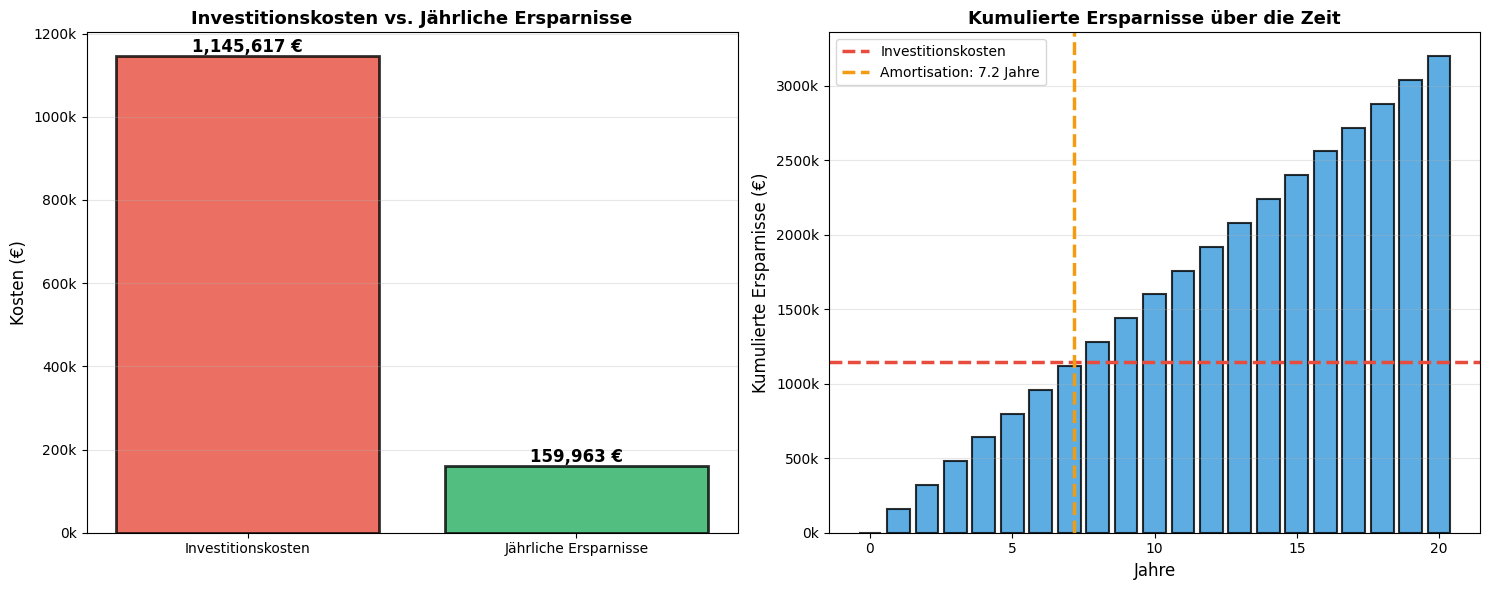


WIRTSCHAFTLICHKEITSANALYSE - ZUSAMMENFASSUNG
Gesamtinvestitionen:              1,145,617 €
Jährliche Ersparnisse:              159,963 €
Amortisationszeit:                     7.16 Jahre
Ersparnisse nach 10 Jahren:       1,599,627 €
Ersparnisse nach 20 Jahren:       3,199,254 €


In [ ]:
# Vergleich: Investitionskosten vs. Ersparnisse

# Investitionskosten (bereits berechnet)
total_investment_costs_plot = total_investment_costs

# Jährliche Ersparnisse (bereits berechnet)
annual_savings_plot = annual_savings

# Erstelle das Balkendiagramm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Diagramm 1: Investitionskosten vs. jährliche Ersparnisse
categories = ['Investitionskosten', 'Jährliche Ersparnisse']
values = [total_investment_costs_plot, annual_savings_plot]
colors = ['#E74C3C', '#27AE60']

bars1 = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Werte auf den Balken anzeigen
for bar, value in zip(bars1, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:,.0f} €',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Kosten (€)', fontsize=12)
ax1.set_title('Investitionskosten vs. Jährliche Ersparnisse', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))

# Diagramm 2: Kumulierte Ersparnisse über Jahre
years = np.arange(0, 21)
cumulative_savings = years * annual_savings_plot
payback_year = total_investment_costs_plot / annual_savings_plot if annual_savings_plot > 0 else 0

ax2.bar(years, cumulative_savings, color='#3498DB', alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=total_investment_costs_plot, color='#E74C3C', linestyle='--', linewidth=2.5, label='Investitionskosten')
ax2.axvline(x=payback_year, color='#F39C12', linestyle='--', linewidth=2.5, label=f'Amortisation: {payback_year:.1f} Jahre')

ax2.set_xlabel('Jahre', fontsize=12)
ax2.set_ylabel('Kumulierte Ersparnisse (€)', fontsize=12)
ax2.set_title('Kumulierte Ersparnisse über die Zeit', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=10, loc='upper left')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

# Zusammenfassung
print("\n" + "="*70)
print("WIRTSCHAFTLICHKEITSANALYSE - ZUSAMMENFASSUNG")
print("="*70)
print(f"Gesamtinvestitionen:           {total_investment_costs_plot:>12,.0f} €")
print(f"Jährliche Ersparnisse:         {annual_savings_plot:>12,.0f} €")
print(f"Amortisationszeit:             {payback_year:>12.2f} Jahre")
print(f"Ersparnisse nach 10 Jahren:    {10 * annual_savings_plot:>12,.0f} €")
print(f"Ersparnisse nach 20 Jahren:    {20 * annual_savings_plot:>12,.0f} €")
print("="*70)

In [ ]:
# Investitionskosten berechnen

# Speicher-Investitionskosten
battery_capacity = with_battery.stores.at["Battery", "e_nom_opt"]  # MWh
battery_cost = with_battery.stores.at["Battery", "capital_cost"]  # €/MWh
battery_investment = battery_capacity * battery_cost

thermal_storage_capacity = with_battery.stores.at["Thermal_Storage", "e_nom_opt"]
thermal_storage_cost = with_battery.stores.at["Thermal_Storage", "capital_cost"]
thermal_storage_investment = thermal_storage_capacity * thermal_storage_cost

dhw_storage_capacity = with_battery.stores.at["DHW_Storage", "e_nom_opt"]
dhw_storage_cost = with_battery.stores.at["DHW_Storage", "capital_cost"]
dhw_storage_investment = dhw_storage_capacity * dhw_storage_cost

# Wärmepumpen-Investitionskosten (falls Sie capital_cost hinzufügen)
h_pump_capacity = with_battery.links.at["h_pump", "p_nom_opt"]  # MW
h_pump2_capacity = with_battery.links.at["h_pump2", "p_nom_opt"]  # MW
# Beispiel: 500.000 €/MW für Wärmepumpen (Sie müssen den realen Wert einsetzen)
h_pump_cost = 500000  # €/MW
h_pump_investment = (h_pump_capacity + h_pump2_capacity) * h_pump_cost

# Gesamte Investitionskosten
total_investment = (battery_investment + thermal_storage_investment + 
                   dhw_storage_investment + h_pump_investment)

print("=" * 50)
print("INVESTITIONSKOSTEN")
print("=" * 50)
print(f"Batteriespeicher: {battery_investment:,.2f} €")
print(f"Wärmespeicher (Heizung): {thermal_storage_investment:,.2f} €")
print(f"Warmwasserspeicher: {dhw_storage_investment:,.2f} €")
print(f"Wärmepumpen: {h_pump_investment:,.2f} €")
print("=" * 50)
print(f"GESAMT: {total_investment:,.2f} €")
print("=" * 50)

INVESTITIONSKOSTEN
Batteriespeicher: -0.00 €
Wärmespeicher (Heizung): 67.31 €
Warmwasserspeicher: 58.52 €
Wärmepumpen: 32,745.69 €
GESAMT: 32,871.53 €


In [ ]:
print("batterie größe: ", with_battery.stores.at["Battery", "e_nom_opt"])
print("thermalstorage größe: ", with_battery.stores.at["Thermal_Storage", "e_nom_opt"]*1000)
print("DHW storage größe: ", with_battery.stores.at["DHW_Storage", "e_nom_opt"]*1000)

batterie größe:  -0.0
thermalstorage größe:  0.22438061192534364
DHW storage größe:  0.19507922605303363


In [ ]:
print(f"Grid Leistung: {with_battery.generators.loc['Grid', 'p_nom_opt']:.2f} MW")
print(f"PV Leistung: {with_battery.generators.loc['PV', 'p_nom_opt']:.2f} MW")
pv_energy = with_battery.generators_t.p["PV"].sum()  
print(f"PV Energieerzeugung über das Jahr: {pv_energy:.2f} MWh")    

print(f"Grid Leistung: {without_battery.generators.loc['Grid', 'p_nom_opt']:.2f} MW")
print(f"PV Leistung: {without_battery.generators.loc['PV', 'p_nom_opt']:.2f} MW")

Grid Leistung: 0.84 MW
PV Leistung: 1.35 MW
PV Energieerzeugung über das Jahr: 661.66 MWh
Grid Leistung: 0.00 MW
PV Leistung: 0.00 MW


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 344.74it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-u2up_jt8 has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e-08, 1e+00]
Presolving model
78840 rows, 65440 cols, 205595 nonzeros  0s
67795 rows, 54395 cols, 186926 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53819 cols, 189439 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53819(-33787); nonzeros 189439(-143447) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6640261674e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.59e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')


      42121     5.5940640754e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-u2up_jt8
Model status        : Optimal
Simplex   iterations: 42121
Objective value     :  5.5940640752e+05
P-D objective error :  6.1390947228e-15
HiGHS run time      :          0.80


Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 301.79it/s]
INFO:linopy.io: Writing time: 0.28s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-7ultwlb1 has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e-08, 2e+00]
Presolving model
78840 rows, 65440 cols, 205595 nonzeros  0s
67795 rows, 54395 cols, 186926 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53819 cols, 189439 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53819(-33787); nonzeros 189439(-143447) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6640261674e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.49e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      41552     5.4914300122e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-7ultwlb1
Model status        : Optimal
Simplex   iterations: 41552
Objective value     :  5.4914300120e+05
P-D objective error :  6.8898165072e-15
HiGHS run time      :          0.74


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 350.79it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-xjutbjo0 has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [2e-08, 3e+00]
Presolving model
78840 rows, 65440 cols, 205595 nonzeros  0s
67795 rows, 54395 cols, 186926 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53819 cols, 189439 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53819(-33787); nonzeros 189439(-143447) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6640261674e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.42e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      41737     5.4205340010e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-xjutbjo0
Model status        : Optimal
Simplex   iterations: 41737
Objective value     :  5.4205340007e+05
P-D objective error :  7.6242305872e-15
HiGHS run time      :          0.89


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 373.39it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-32mur6ky has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [2e-08, 3e+00]
Presolving model
78840 rows, 65441 cols, 205596 nonzeros  0s
67795 rows, 54396 cols, 186927 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53820 cols, 189440 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53820(-33786); nonzeros 189440(-143446) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6681383092e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.37e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      41472     5.3720609917e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-32mur6ky
Model status        : Optimal
Simplex   iterations: 41472
Objective value     :  5.3720609916e+05
P-D objective error :  6.9345579602e-15
HiGHS run time      :          0.89


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 368.19it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-4i2bgcof has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [3e-08, 4e+00]
Presolving model
78840 rows, 65442 cols, 205597 nonzeros  0s
67795 rows, 54397 cols, 186928 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53821 cols, 189441 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53821(-33785); nonzeros 189441(-143445) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6686634382e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.34e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      41252     5.3355244800e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-4i2bgcof
Model status        : Optimal
Simplex   iterations: 41252
Objective value     :  5.3355244800e+05
P-D objective error :  6.3274776115e-15
HiGHS run time      :          0.87


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 386.67it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-k_gq1umf has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e-07, 1e+01]
Presolving model
78840 rows, 65442 cols, 205597 nonzeros  0s
67795 rows, 54397 cols, 186928 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53821 cols, 189441 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53821(-33785); nonzeros 189441(-143445) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6686634382e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.15e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      40531     5.1520092870e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-k_gq1umf
Model status        : Optimal
Simplex   iterations: 40531
Objective value     :  5.1520092869e+05
P-D objective error :  7.8521374519e-15
HiGHS run time      :          0.85

Sensitivitätsanalyse: Einfluss der PV-Leistung auf Netzbezug und Autarkie
                 PV-Leistung 1  PV-Leistung 1.5  PV-Leistung 2  \
Netzbezug (MWh)        3291.93          3223.51        3176.24   
Autarkie (%)             16.74            18.47          19.66   

                 PV-Leistung 2.5  PV-Leistung 3  PV-Leistung 10  
Netzbezug (MWh)          3143.93        3119.57         2997.22  
Autarkie (%)               20.48          21.10           24.19  


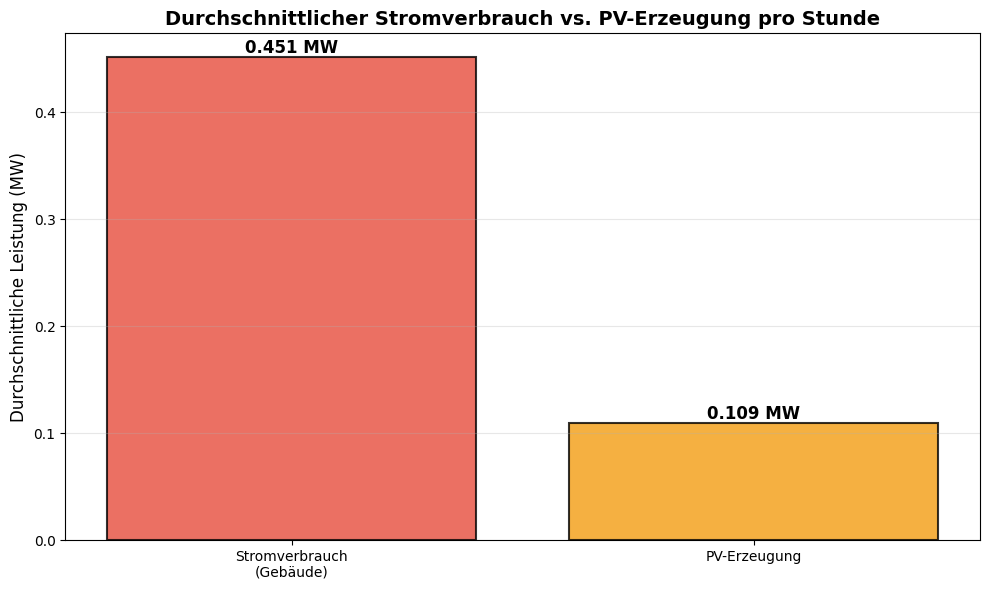

In [ ]:
# Balkendiagramm: Durchschnittlicher Stromverbrauch vs. PV-Erzeugung
avg_building_load = total_electricity_demand / 8760
avg_pv_generation = pv_energy / 8760

plt.figure(figsize=(10, 6))
categories = ['Stromverbrauch\n(Gebäude)', 'PV-Erzeugung']
values = [avg_building_load, avg_pv_generation]
colors = ['#E74C3C', '#F39C12']

bars = plt.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Werte auf den Balken anzeigen
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f} MW',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Durchschnittliche Leistung (MW)', fontsize=12)
plt.title('Durchschnittlicher Stromverbrauch vs. PV-Erzeugung pro Stunde', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

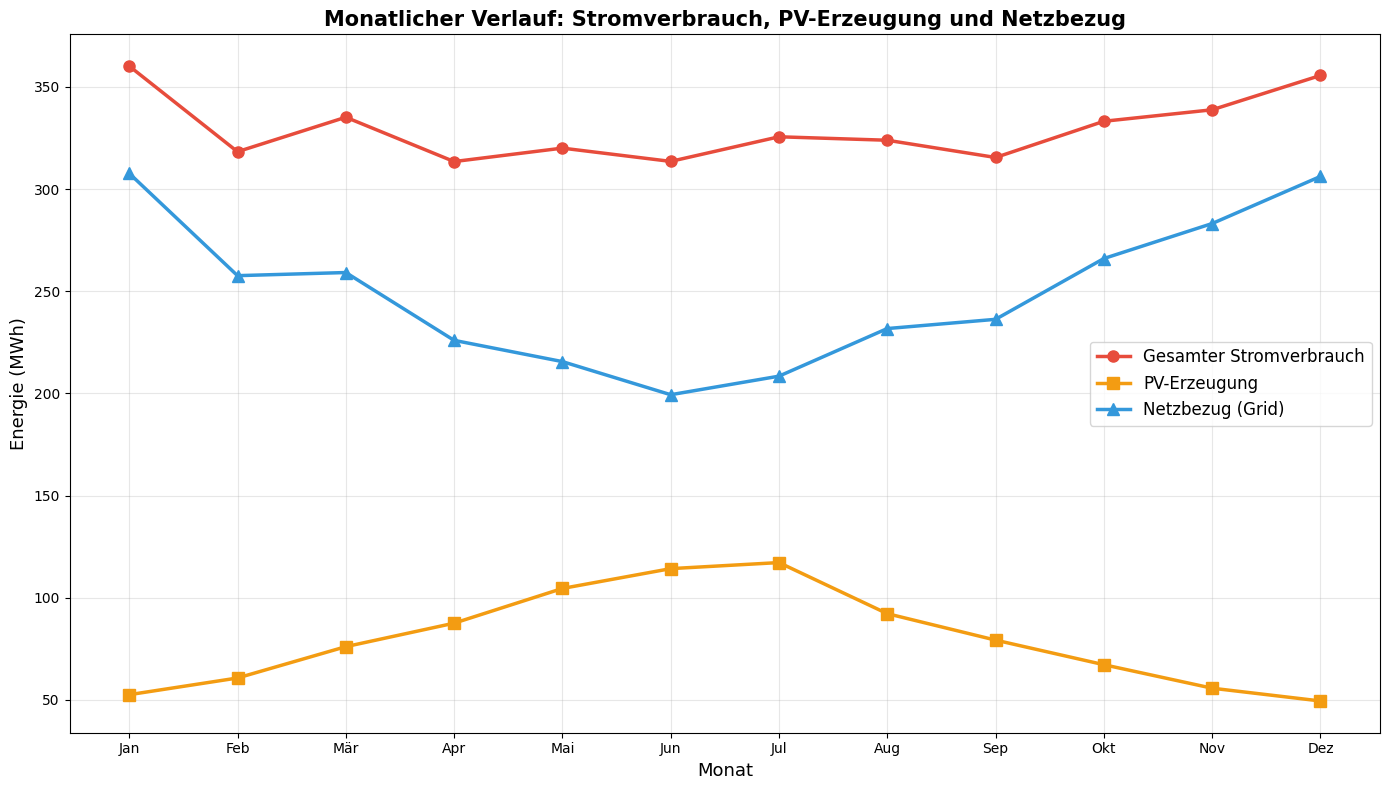

In [ ]:
# Plot: Monatlicher Verlauf von Stromverbrauch, Grid-Bezug und PV-Erzeugung
plt.figure(figsize=(14, 8))

# Gesamter Stromverbrauch (direkt + Wärmepumpen)
total_load = (with_battery.loads_t.p["building_load"] + 
              with_battery.loads_t.p["fleet_load"] + 
              with_battery.links_t.p0["h_pump"] + 
              with_battery.links_t.p0["h_pump2"]).values

# PV-Erzeugung
pv_generation = with_battery.generators_t.p["PV"].values

# Grid-Bezug
grid_power = with_battery.generators_t.p["Grid"].values

# Umwandlung in monatliche Summen (MWh)
hours_per_month = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]  # Stunden pro Monat
months = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']

monthly_load = []
monthly_pv = []
monthly_grid = []

start_hour = 0
for hours in hours_per_month:
    end_hour = start_hour + hours
    monthly_load.append(total_load[start_hour:end_hour].sum())
    monthly_pv.append(pv_generation[start_hour:end_hour].sum())
    monthly_grid.append(grid_power[start_hour:end_hour].sum())
    start_hour = end_hour

# Plots
plt.plot(months, monthly_load, label='Gesamter Stromverbrauch', linewidth=2.5, color='#E74C3C', marker='o', markersize=8)
plt.plot(months, monthly_pv, label='PV-Erzeugung', linewidth=2.5, color='#F39C12', marker='s', markersize=8)
plt.plot(months, monthly_grid, label='Netzbezug (Grid)', linewidth=2.5, color='#3498DB', marker='^', markersize=8)

plt.xlabel('Monat', fontsize=13)
plt.ylabel('Energie (MWh)', fontsize=13)
plt.title('Monatlicher Verlauf: Stromverbrauch, PV-Erzeugung und Netzbezug', fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()